## 0. Import some necessary modules

In [26]:
from pickle import load
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from pickle import load, dump, HIGHEST_PROTOCOL
import xgboost as xgb
from sklearn.decomposition import PCA
import os
%matplotlib inline

## 1. Find out the easily confusable categories for each category based on the predictions of the fine-tuned mode in stage I on both training and test sets
### 1.1 Load the necessary data previously saved in the stage I

In [44]:
# Load the true labels for the images of training and test sets
with open('datasets/train_i1.pickle', 'rb') as f:
    train_set = np.array(load(f))  
with open('datasets/valid_i1.pickle', 'rb') as f:
    valid_set = np.array(load(f))

labels_train = train_set[:,1].astype('int')
labels_valid = valid_set[:,1].astype('int')

In [45]:
# Load the predicted labels for the images of training and test sets
with open('prediction/fine3_train.pickle', 'rb') as f:
    predictions_train = np.array(load(f))
with open('prediction/fine3_valid.pickle', 'rb') as f:
    predictions_valid = np.array(load(f))

### 1.2 Calculate the confusion matrix for both the training and validation set respectively and then merge them into a total confusion matrix

In [46]:
from collections import Counter

matrix_train = []
for category in tqdm(range(5270)):
    entry = []
    indices = [i for i, j in enumerate(predictions_train) if j == category ]
    c = Counter(labels_train[indices]) 
    total_n = len(indices)
    for cate in range(5270):
        if cate not in c.keys():
            entry.append(0)
        else:
            entry.append(c[cate])
    matrix_train.append(entry)
matrix_train = np.array(matrix_train)

matrix_valid = []
for category in tqdm(range(5270)):
    entry = []
    indices = [i for i, j in enumerate(predictions_valid) if j == category ]
    c = Counter(labels_valid[indices]) 
    total_n = len(indices)
    for cate in range(5270):
        if cate not in c.keys():
            entry.append(0)
        else:
            entry.append(c[cate])
    matrix_valid.append(entry)
matrix_valid = np.array(matrix_valid)
    

100%|██████████| 5270/5270 [01:45<00:00, 49.82it/s]


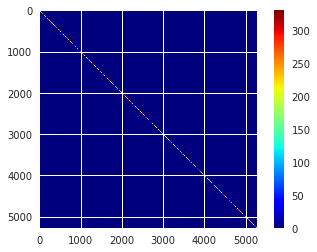

In [49]:
# Merge the two confusiong matrix
matrix_total = matrix_train + matrix_valid

# Visualize the total confusiong matrix
plt.imshow(matrix_total, cmap='jet')
plt.colorbar()

### 1.3 Condense the confusion matrix

In [50]:
# For each category, list the indices of all its true and false negative categories 
# as well as their number of occurance in the training and testing sets
matrix_total_c = []
for i in matrix_total:
    item = [[ind, j] for ind, j in enumerate(i) if j] # [..., [index_category_i, number of counts], ...]
    matrix_total_c.append(item)

In [51]:
# Example: true and false categories for category 1340
item = matrix_total_c[1340]
pprint(sorted(item, key=lambda x: x[1], reverse=True))

[[1340, 244],
 [1844, 6],
 [1330, 4],
 [177, 3],
 [1302, 2],
 [67, 1],
 [99, 1],
 [284, 1],
 [355, 1],
 [665, 1],
 [931, 1],
 [1090, 1],
 [1112, 1],
 [1117, 1],
 [1177, 1],
 [1200, 1],
 [1219, 1],
 [1224, 1],
 [1260, 1],
 [1322, 1],
 [1338, 1],
 [1395, 1],
 [1633, 1],
 [1763, 1],
 [1806, 1],
 [1845, 1],
 [2412, 1],
 [2555, 1],
 [2743, 1],
 [2796, 1],
 [2805, 1],
 [2811, 1],
 [2887, 1],
 [3488, 1],
 [3548, 1],
 [3934, 1],
 [4061, 1]]


Totally in the training and the validation set, the category 0 was successfully identified for 21 times but was wrongly recognized as the category 3195 for 2 times, as the category 3206 for 2 times, as the category 461 for 1 time and so on.

### 1.4 Identify the easily confusable categories 

In [85]:
subsets = {} # the keys are the indices of categories from 0 to 5269, the values are lists that contain the categories themself and their corresponding easily confusable categories

# If category_m is misclassified as category_n for more than one times in the training and test set
# category_m will be added to the list of easily confusable categories of category_n located at subsets[category_n]:
for i in range(5270):
    confusions = matrix_total_c[i]
    if len(confusions)>1: 
        subsets[i] = [n[0] for n in confusions if n[1] > 1]
        if len(subsets[i]) < 2:
            subsets[i] = None
    else:
        subsets[i] =  None

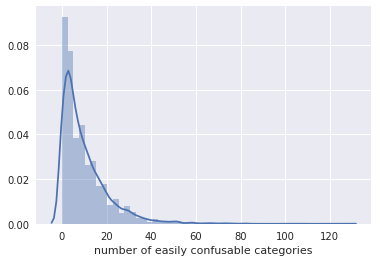

In [78]:
# Calculate the number of easily confusable categories for each category
matrix_len = pd.Series([len(subsets[k]) if isinstance(subsets[k], list) else 0 for k in subsets.keys()], name="number of easily confusable categories")

# Visualize the distribution of the number of easily confusable categories across
sns.distplot(matrix_len)

## 2. Train the sets of xgboost classifiers for each category among its easily confusable categories
### 2.1 Load the previously calculated bottleneck features

In [11]:
from pickle import load

with open('bnfeature/train_fine_3fs.pickle', 'rb') as f:
    bnf_train = load(f)

### 2.2 Tune and setup the hyper-parameters for training the xgboost classifiers
#### 2.2a Tune the hyper-parameters

In [1]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

seed = 42
params_grid = dict(max_depth=[1,2,3], n_estimators=[5,10,25,50], learning_rate=[0.1,0.3,0.9])

params_fixed = dict(objective='multi:softmax', silent=1)
bst_grid = GridSearchCV(estimator=XGBClassifier(**params_fixed, seed=seed),
                       param_grid=param_grid)

In [ ]:
# The hyper-parameter tuning will be performed on a reduced training set
# which consists of all the training samples from category 0 and those from
# the easily confusable categories of category 0


cat_tune = 0
cats = subsets[cat_tune] # Category 0 and its easily confusable categories
train_x, train_y= [], []

# Establish the reduced training set to discriminate category 0 and 
# its easily confusable categories

for nr, cat in enumerate(cats):
    bnf_sec = bnf_train[cat]
    bnf_sec = [list(bnf) for bnf in bnf_sec]
    train_x+=(bnf_sec)
    train_y+=[nr]*len(bnf_sec)

train_x = np.array(train_x)
train_y = np.array(train_y)  

xg_train = xgb.DMatrix(train_x, label=train_y)

In [ ]:
bst_grid.fit(train_x, train_y)

#### 2.2b Use the tuned hyper-parameters

In [12]:
param = {}

param['objective'] = 'multi:softmax'
param['eta'] = 0.3
param['max_depth'] = 3
param['silent'] = 1
param['tree_method'] = 'auto'

### 2.3 Train the sets of XGBoost classifiers

In [13]:
from random import shuffle
from sklearn.decomposition import PCA

cats_total = 5270 # train a xgboost classifier for each category
batch_size = 50 # organize the training process in batches of 50 categories
batch_n = int(np.ceil(cats_total/batch_size)) # total number of batches

for m in tqdm(range(0, batch_n)):
    classifiers = []  
    begin = m*batch_size
    if m == batch_n-1:
        end = 5270
    else:
        end = (m+1)*batch_size
    for i in range(begin, end):
        print("Train the classifier for category %d" % i)
        # Get the list that includes category i and its easy confusable categories
        cats = subsets[i] 

        if isinstance(cats,list):
            train_x, train_y= [], []
            
            # To establish a reduced training set for each category,
            # where only the training samples from this category
            for nr, cat in enumerate(cats):
                bnf_sec = bnf_train[cat]
                bnf_sec = [list(bnf) for bnf in bnf_sec]
                train_x+=(bnf_sec)
                train_y+=[nr]*len(bnf_sec)

            train_x = np.array(train_x)
            train_y = np.array(train_y)  
   
            xg_train = xgb.DMatrix(train_x, label=train_y)

            num_round = 50
            param['num_class'] = len(cats)

            bst = xgb.train(param, xg_train, num_round)
            
            item = {} 
            item['cats'] = cats 
            item['clf'] = bst
            classifiers.append(item)

            classifiers.append(classifiers[cats])
        else:
            classifiers.append(None)
    
    # Save the trained classifiers periodically to prevent data loss due to expected interruptions
    with open("classifiers/classifier_batch_%d" %m, 'wb') as f:
        dump(classifiers, f, HIGHEST_PROTOCOL)
     

    

  0%|          | 0/45 [00:00<?, ?it/s]

Cat: 3050
Cat: 3051
Cat: 3052
Cat: 3053
Cat: 3054
Cat: 3055
Cat: 3056
Cat: 3057
Cat: 3058
Cat: 3059
Cat: 3060
Cat: 3061
Cat: 3062
Cat: 3063
Cat: 3064
Cat: 3065
Cat: 3066
Cat: 3067
Cat: 3068
Cat: 3069
Cat: 3070
Cat: 3071
Cat: 3072
Cat: 3073
Cat: 3074
Cat: 3075
Cat: 3076
Cat: 3077
Cat: 3078
Cat: 3079
Cat: 3080
Cat: 3081
Cat: 3082
Cat: 3083
Cat: 3084
Cat: 3085
Cat: 3086
Cat: 3087
Cat: 3088
Cat: 3089
Cat: 3090
Cat: 3091
Cat: 3092
Cat: 3093
Cat: 3094
Cat: 3095
Cat: 3096
Cat: 3097
Cat: 3098
Cat: 3099


  2%|▏         | 1/45 [2:32:57<112:09:51, 9177.07s/it]

Cat: 3100
Cat: 3101
Cat: 3102
Cat: 3103
Cat: 3104
Cat: 3105
Cat: 3106
Cat: 3107
Cat: 3108
Cat: 3109
Cat: 3110
Cat: 3111
Cat: 3112
Cat: 3113
Cat: 3114
Cat: 3115
Cat: 3116
Cat: 3117
Cat: 3118
Cat: 3119
Cat: 3120
Cat: 3121
Cat: 3122
Cat: 3123
Cat: 3124
Cat: 3125
Cat: 3126
Cat: 3127
Cat: 3128
Cat: 3129
Cat: 3130
Cat: 3131
Cat: 3132
Cat: 3133
Cat: 3134
Cat: 3135
Cat: 3136
Cat: 3137
Cat: 3138
Cat: 3139
Cat: 3140
Cat: 3141
Cat: 3142
Cat: 3143
Cat: 3144
Cat: 3145
Cat: 3146
Cat: 3147
Cat: 3148
Cat: 3149


  4%|▍         | 2/45 [5:53:36<126:42:35, 10608.27s/it]

Cat: 3150
Cat: 3151
Cat: 3152
Cat: 3153
Cat: 3154
Cat: 3155
Cat: 3156
Cat: 3157
Cat: 3158
Cat: 3159
Cat: 3160
Cat: 3161
Cat: 3162
Cat: 3163
Cat: 3164
Cat: 3165
Cat: 3166
Cat: 3167
Cat: 3168
Cat: 3169
Cat: 3170
Cat: 3171
Cat: 3172
Cat: 3173
Cat: 3174
Cat: 3175
Cat: 3176
Cat: 3177
Cat: 3178
Cat: 3179
Cat: 3180
Cat: 3181
Cat: 3182
Cat: 3183
Cat: 3184
Cat: 3185
Cat: 3186
Cat: 3187
Cat: 3188
Cat: 3189
Cat: 3190
Cat: 3191
Cat: 3192
Cat: 3193
Cat: 3194
Cat: 3195
Cat: 3196
Cat: 3197
Cat: 3198
Cat: 3199


  7%|▋         | 3/45 [7:10:30<100:27:05, 8610.13s/it] 

Cat: 3200
Cat: 3201
Cat: 3202
Cat: 3203
Cat: 3204
Cat: 3205
Cat: 3206
Cat: 3207
Cat: 3208
Cat: 3209
Cat: 3210
Cat: 3211
Cat: 3212
Cat: 3213
Cat: 3214
Cat: 3215
Cat: 3216
Cat: 3217
Cat: 3218
Cat: 3219
Cat: 3220
Cat: 3221
Cat: 3222
Cat: 3223
Cat: 3224
Cat: 3225
Cat: 3226
Cat: 3227
Cat: 3228
Cat: 3229
Cat: 3230
Cat: 3231
Cat: 3232
Cat: 3233
Cat: 3234
Cat: 3235
Cat: 3236
Cat: 3237
Cat: 3238
Cat: 3239
Cat: 3240
Cat: 3241
Cat: 3242
Cat: 3243
Cat: 3244
Cat: 3245
Cat: 3246
Cat: 3247
Cat: 3248
Cat: 3249


  9%|▉         | 4/45 [9:21:03<95:50:52, 8415.91s/it] 

Cat: 3250
Cat: 3251
Cat: 3252
Cat: 3253
Cat: 3254
Cat: 3255
Cat: 3256
Cat: 3257
Cat: 3258
Cat: 3259
Cat: 3260
Cat: 3261
Cat: 3262
Cat: 3263
Cat: 3264
Cat: 3265
Cat: 3266
Cat: 3267
Cat: 3268
Cat: 3269
Cat: 3270
Cat: 3271
Cat: 3272
Cat: 3273
Cat: 3274
Cat: 3275
Cat: 3276
Cat: 3277
Cat: 3278
Cat: 3279
Cat: 3280
Cat: 3281
Cat: 3282
Cat: 3283
Cat: 3284
Cat: 3285
Cat: 3286
Cat: 3287
Cat: 3288
Cat: 3289
Cat: 3290
Cat: 3291
Cat: 3292
Cat: 3293
Cat: 3294
Cat: 3295
Cat: 3296
Cat: 3297
Cat: 3298
Cat: 3299


 11%|█         | 5/45 [18:52:52<151:02:59, 13594.49s/it]

Cat: 3300
Cat: 3301
Cat: 3302
Cat: 3303
Cat: 3304
Cat: 3305
Cat: 3306
Cat: 3307
Cat: 3308
Cat: 3309
Cat: 3310
Cat: 3311
Cat: 3312
Cat: 3313
Cat: 3314
Cat: 3315
Cat: 3316
Cat: 3317
Cat: 3318
Cat: 3319
Cat: 3320
Cat: 3321
Cat: 3322
Cat: 3323
Cat: 3324
Cat: 3325
Cat: 3326
Cat: 3327
Cat: 3328
Cat: 3329
Cat: 3330
Cat: 3331
Cat: 3332
Cat: 3333
Cat: 3334
Cat: 3335
Cat: 3336
Cat: 3337
Cat: 3338
Cat: 3339
Cat: 3340
Cat: 3341
Cat: 3342
Cat: 3343
Cat: 3344
Cat: 3345
Cat: 3346
Cat: 3347
Cat: 3348
Cat: 3349


 13%|█▎        | 6/45 [29:26:09<191:20:02, 17661.61s/it]

Cat: 3350
Cat: 3351
Cat: 3352
Cat: 3353
Cat: 3354
Cat: 3355
Cat: 3356
Cat: 3357
Cat: 3358
Cat: 3359
Cat: 3360
Cat: 3361
Cat: 3362
Cat: 3363
Cat: 3364
Cat: 3365
Cat: 3366
Cat: 3367
Cat: 3368
Cat: 3369
Cat: 3370
Cat: 3371
Cat: 3372
Cat: 3373
Cat: 3374
Cat: 3375
Cat: 3376
Cat: 3377
Cat: 3378
Cat: 3379
Cat: 3380
Cat: 3381
Cat: 3382
Cat: 3383
Cat: 3384
Cat: 3385
Cat: 3386
Cat: 3387
Cat: 3388
Cat: 3389
Cat: 3390
Cat: 3391
Cat: 3392
Cat: 3393
Cat: 3394
Cat: 3395
Cat: 3396
Cat: 3397
Cat: 3398
Cat: 3399


 16%|█▌        | 7/45 [40:22:12<219:09:05, 20761.72s/it]

Cat: 3400
Cat: 3401
Cat: 3402
Cat: 3403
Cat: 3404
Cat: 3405
Cat: 3406
Cat: 3407
Cat: 3408
Cat: 3409
Cat: 3410
Cat: 3411
Cat: 3412
Cat: 3413
Cat: 3414
Cat: 3415
Cat: 3416
Cat: 3417
Cat: 3418
Cat: 3419
Cat: 3420
Cat: 3421
Cat: 3422
Cat: 3423
Cat: 3424
Cat: 3425
Cat: 3426
Cat: 3427
Cat: 3428
Cat: 3429
Cat: 3430
Cat: 3431
Cat: 3432
Cat: 3433
Cat: 3434
Cat: 3435
Cat: 3436
Cat: 3437
Cat: 3438
Cat: 3439
Cat: 3440
Cat: 3441
Cat: 3442
Cat: 3443
Cat: 3444
Cat: 3445
Cat: 3446
Cat: 3447
Cat: 3448
Cat: 3449


 18%|█▊        | 8/45 [40:50:09<188:52:01, 18376.25s/it]

Cat: 3450
Cat: 3451
Cat: 3452
Cat: 3453
Cat: 3454
Cat: 3455
Cat: 3456
Cat: 3457
Cat: 3458
Cat: 3459
Cat: 3460
Cat: 3461
Cat: 3462
Cat: 3463
Cat: 3464
Cat: 3465
Cat: 3466
Cat: 3467
Cat: 3468
Cat: 3469
Cat: 3470
Cat: 3471
Cat: 3472
Cat: 3473
Cat: 3474
Cat: 3475
Cat: 3476
Cat: 3477
Cat: 3478
Cat: 3479
Cat: 3480
Cat: 3481
Cat: 3482
Cat: 3483
Cat: 3484
Cat: 3485
Cat: 3486
Cat: 3487
Cat: 3488
Cat: 3489
Cat: 3490
Cat: 3491
Cat: 3492
Cat: 3493
Cat: 3494
Cat: 3495
Cat: 3496
Cat: 3497
Cat: 3498


 20%|██        | 9/45 [41:26:57<165:47:51, 16579.76s/it]

Cat: 3499
Cat: 3500
Cat: 3501
Cat: 3502
Cat: 3503
Cat: 3504
Cat: 3505
Cat: 3506
Cat: 3507
Cat: 3508
Cat: 3509
Cat: 3510
Cat: 3511
Cat: 3512
Cat: 3513
Cat: 3514
Cat: 3515
Cat: 3516
Cat: 3517
Cat: 3518
Cat: 3519
Cat: 3520
Cat: 3521
Cat: 3522
Cat: 3523
Cat: 3524
Cat: 3525
Cat: 3526
Cat: 3527
Cat: 3528
Cat: 3529
Cat: 3530
Cat: 3531
Cat: 3532
Cat: 3533
Cat: 3534
Cat: 3535
Cat: 3536
Cat: 3537
Cat: 3538
Cat: 3539
Cat: 3540
Cat: 3541
Cat: 3542
Cat: 3543
Cat: 3544
Cat: 3545
Cat: 3546
Cat: 3547
Cat: 3548


 22%|██▏       | 10/45 [41:53:05<146:35:50, 15078.57s/it]

Cat: 3549
Cat: 3550
Cat: 3551
Cat: 3552
Cat: 3553
Cat: 3554
Cat: 3555
Cat: 3556
Cat: 3557
Cat: 3558
Cat: 3559
Cat: 3560
Cat: 3561
Cat: 3562
Cat: 3563
Cat: 3564
Cat: 3565
Cat: 3566
Cat: 3567
Cat: 3568
Cat: 3569
Cat: 3570
Cat: 3571
Cat: 3572
Cat: 3573
Cat: 3574
Cat: 3575
Cat: 3576
Cat: 3577
Cat: 3578
Cat: 3579
Cat: 3580
Cat: 3581
Cat: 3582
Cat: 3583
Cat: 3584
Cat: 3585
Cat: 3586
Cat: 3587
Cat: 3588
Cat: 3589
Cat: 3590
Cat: 3591
Cat: 3592
Cat: 3593
Cat: 3594
Cat: 3595
Cat: 3596
Cat: 3597
Cat: 3598
Cat: 3599


 24%|██▍       | 11/45 [42:36:19<131:41:21, 13943.57s/it]

Cat: 3600
Cat: 3601
Cat: 3602
Cat: 3603
Cat: 3604
Cat: 3605
Cat: 3606
Cat: 3607
Cat: 3608
Cat: 3609
Cat: 3610
Cat: 3611
Cat: 3612
Cat: 3613
Cat: 3614
Cat: 3615
Cat: 3616
Cat: 3617
Cat: 3618
Cat: 3619
Cat: 3620
Cat: 3621
Cat: 3622
Cat: 3623
Cat: 3624
Cat: 3625
Cat: 3626
Cat: 3627
Cat: 3628
Cat: 3629
Cat: 3630
Cat: 3631
Cat: 3632
Cat: 3633
Cat: 3634
Cat: 3635
Cat: 3636
Cat: 3637
Cat: 3638
Cat: 3639
Cat: 3640
Cat: 3641
Cat: 3642
Cat: 3643
Cat: 3644
Cat: 3645
Cat: 3646
Cat: 3647
Cat: 3648
Cat: 3649


 27%|██▋       | 12/45 [43:39:32<120:03:44, 13097.71s/it]

Cat: 3650
Cat: 3651
Cat: 3652
Cat: 3653
Cat: 3654
Cat: 3655
Cat: 3656
Cat: 3657
Cat: 3658
Cat: 3659
Cat: 3660
Cat: 3661
Cat: 3662
Cat: 3663
Cat: 3664
Cat: 3665
Cat: 3666
Cat: 3667
Cat: 3668
Cat: 3669
Cat: 3670
Cat: 3671
Cat: 3672
Cat: 3673
Cat: 3674
Cat: 3675
Cat: 3676
Cat: 3677
Cat: 3678
Cat: 3679
Cat: 3680
Cat: 3681
Cat: 3682
Cat: 3683
Cat: 3684
Cat: 3685
Cat: 3686
Cat: 3687
Cat: 3688
Cat: 3689
Cat: 3690
Cat: 3691
Cat: 3692
Cat: 3693
Cat: 3694
Cat: 3695
Cat: 3696
Cat: 3697
Cat: 3698
Cat: 3699


 29%|██▉       | 13/45 [43:58:43<108:15:20, 12178.75s/it]

Cat: 3700
Cat: 3701
Cat: 3702
Cat: 3703
Cat: 3704
Cat: 3705
Cat: 3706
Cat: 3707
Cat: 3708
Cat: 3709
Cat: 3710
Cat: 3711
Cat: 3712
Cat: 3713
Cat: 3714
Cat: 3715
Cat: 3716
Cat: 3717
Cat: 3718
Cat: 3719
Cat: 3720
Cat: 3721
Cat: 3722
Cat: 3723
Cat: 3724
Cat: 3725
Cat: 3726
Cat: 3727
Cat: 3728
Cat: 3729
Cat: 3730
Cat: 3731
Cat: 3732
Cat: 3733
Cat: 3734
Cat: 3735
Cat: 3736
Cat: 3737
Cat: 3738
Cat: 3739
Cat: 3740
Cat: 3741
Cat: 3742
Cat: 3743
Cat: 3744
Cat: 3745
Cat: 3746
Cat: 3747
Cat: 3748


 31%|███       | 14/45 [44:03:59<97:34:32, 11331.38s/it] 

Cat: 3749
Cat: 3750
Cat: 3751
Cat: 3752
Cat: 3753
Cat: 3754
Cat: 3755
Cat: 3756
Cat: 3757
Cat: 3758
Cat: 3759
Cat: 3760
Cat: 3761
Cat: 3762
Cat: 3763
Cat: 3764
Cat: 3765
Cat: 3766
Cat: 3767
Cat: 3768
Cat: 3769
Cat: 3770
Cat: 3771
Cat: 3772
Cat: 3773
Cat: 3774
Cat: 3775
Cat: 3776
Cat: 3777
Cat: 3778
Cat: 3779
Cat: 3780
Cat: 3781
Cat: 3782
Cat: 3783
Cat: 3784
Cat: 3785
Cat: 3786
Cat: 3787
Cat: 3788
Cat: 3789
Cat: 3790
Cat: 3791
Cat: 3792
Cat: 3793
Cat: 3794
Cat: 3795
Cat: 3796
Cat: 3797
Cat: 3798
Cat: 3799


 33%|███▎      | 15/45 [44:12:16<88:24:32, 10609.09s/it]

Cat: 3800
Cat: 3801
Cat: 3802
Cat: 3803
Cat: 3804
Cat: 3805
Cat: 3806
Cat: 3807
Cat: 3808
Cat: 3809
Cat: 3810
Cat: 3811
Cat: 3812
Cat: 3813
Cat: 3814
Cat: 3815
Cat: 3816
Cat: 3817
Cat: 3818
Cat: 3819
Cat: 3820
Cat: 3821
Cat: 3822
Cat: 3823
Cat: 3824
Cat: 3825
Cat: 3826
Cat: 3827
Cat: 3828
Cat: 3829
Cat: 3830
Cat: 3831
Cat: 3832
Cat: 3833
Cat: 3834
Cat: 3835
Cat: 3836
Cat: 3837
Cat: 3838
Cat: 3839
Cat: 3840
Cat: 3841
Cat: 3842
Cat: 3843
Cat: 3844
Cat: 3845
Cat: 3846
Cat: 3847
Cat: 3848
Cat: 3849


 36%|███▌      | 16/45 [44:41:37<81:00:25, 10056.06s/it]

Cat: 3850
Cat: 3851
Cat: 3852
Cat: 3853
Cat: 3854
Cat: 3855
Cat: 3856
Cat: 3857
Cat: 3858
Cat: 3859
Cat: 3860
Cat: 3861
Cat: 3862
Cat: 3863
Cat: 3864
Cat: 3865
Cat: 3866
Cat: 3867
Cat: 3868
Cat: 3869
Cat: 3870
Cat: 3871
Cat: 3872
Cat: 3873
Cat: 3874
Cat: 3875
Cat: 3876
Cat: 3877
Cat: 3878
Cat: 3879
Cat: 3880
Cat: 3881
Cat: 3882
Cat: 3883
Cat: 3884
Cat: 3885
Cat: 3886
Cat: 3887
Cat: 3888
Cat: 3889
Cat: 3890
Cat: 3891
Cat: 3892
Cat: 3893
Cat: 3894
Cat: 3895
Cat: 3896
Cat: 3897
Cat: 3898
Cat: 3899


 38%|███▊      | 17/45 [45:13:19<74:29:00, 9576.43s/it] 

Cat: 3900
Cat: 3901
Cat: 3902
Cat: 3903
Cat: 3904
Cat: 3905
Cat: 3906
Cat: 3907
Cat: 3908
Cat: 3909
Cat: 3910
Cat: 3911
Cat: 3912
Cat: 3913
Cat: 3914
Cat: 3915
Cat: 3916
Cat: 3917
Cat: 3918
Cat: 3919
Cat: 3920
Cat: 3921
Cat: 3922
Cat: 3923
Cat: 3924
Cat: 3925
Cat: 3926
Cat: 3927
Cat: 3928
Cat: 3929
Cat: 3930
Cat: 3931
Cat: 3932
Cat: 3933
Cat: 3934
Cat: 3935
Cat: 3936
Cat: 3937
Cat: 3938
Cat: 3939
Cat: 3940
Cat: 3941
Cat: 3942
Cat: 3943
Cat: 3944
Cat: 3945
Cat: 3946
Cat: 3947
Cat: 3948
Cat: 3949


 40%|████      | 18/45 [46:43:17<70:04:56, 9344.32s/it]

Cat: 3950
Cat: 3951
Cat: 3952
Cat: 3953
Cat: 3954
Cat: 3955
Cat: 3956
Cat: 3957
Cat: 3958
Cat: 3959
Cat: 3960
Cat: 3961
Cat: 3962
Cat: 3963
Cat: 3964
Cat: 3965
Cat: 3966
Cat: 3967
Cat: 3968
Cat: 3969
Cat: 3970
Cat: 3971
Cat: 3972
Cat: 3973
Cat: 3974
Cat: 3975
Cat: 3976
Cat: 3977
Cat: 3978
Cat: 3979
Cat: 3980
Cat: 3981
Cat: 3982
Cat: 3983
Cat: 3984
Cat: 3985
Cat: 3986
Cat: 3987
Cat: 3988
Cat: 3989
Cat: 3990
Cat: 3991
Cat: 3992
Cat: 3993
Cat: 3994
Cat: 3995
Cat: 3996
Cat: 3997
Cat: 3998
Cat: 3999


 42%|████▏     | 19/45 [48:04:50<65:47:41, 9110.05s/it]

Cat: 4000
Cat: 4001
Cat: 4002
Cat: 4003
Cat: 4004
Cat: 4005
Cat: 4006
Cat: 4007
Cat: 4008
Cat: 4009
Cat: 4010
Cat: 4011
Cat: 4012
Cat: 4013
Cat: 4014
Cat: 4015
Cat: 4016
Cat: 4017
Cat: 4018
Cat: 4019
Cat: 4020
Cat: 4021
Cat: 4022
Cat: 4023
Cat: 4024
Cat: 4025
Cat: 4026
Cat: 4027
Cat: 4028
Cat: 4029
Cat: 4030
Cat: 4031
Cat: 4032
Cat: 4033
Cat: 4034
Cat: 4035
Cat: 4036
Cat: 4037
Cat: 4038
Cat: 4039
Cat: 4040
Cat: 4041
Cat: 4042
Cat: 4043
Cat: 4044
Cat: 4045
Cat: 4046
Cat: 4047
Cat: 4048
Cat: 4049


 44%|████▍     | 20/45 [49:27:31<61:49:24, 8902.57s/it]

Cat: 4050
Cat: 4051
Cat: 4052
Cat: 4053
Cat: 4054
Cat: 4055
Cat: 4056
Cat: 4057
Cat: 4058
Cat: 4059
Cat: 4060
Cat: 4061
Cat: 4062
Cat: 4063
Cat: 4064
Cat: 4065
Cat: 4066
Cat: 4067
Cat: 4068
Cat: 4069
Cat: 4070
Cat: 4071
Cat: 4072
Cat: 4073
Cat: 4074
Cat: 4075
Cat: 4076
Cat: 4077
Cat: 4078
Cat: 4079
Cat: 4080
Cat: 4081
Cat: 4082
Cat: 4083
Cat: 4084
Cat: 4085
Cat: 4086
Cat: 4087
Cat: 4088
Cat: 4089
Cat: 4090
Cat: 4091
Cat: 4092
Cat: 4093
Cat: 4094
Cat: 4095
Cat: 4096
Cat: 4097
Cat: 4098
Cat: 4099


 47%|████▋     | 21/45 [50:55:56<58:12:30, 8731.28s/it]

Cat: 4100
Cat: 4101
Cat: 4102
Cat: 4103
Cat: 4104
Cat: 4105
Cat: 4106
Cat: 4107
Cat: 4108
Cat: 4109
Cat: 4110
Cat: 4111
Cat: 4112
Cat: 4113
Cat: 4114
Cat: 4115
Cat: 4116
Cat: 4117
Cat: 4118
Cat: 4119
Cat: 4120
Cat: 4121
Cat: 4122
Cat: 4123
Cat: 4124
Cat: 4125
Cat: 4126
Cat: 4127
Cat: 4128
Cat: 4129
Cat: 4130
Cat: 4131
Cat: 4132
Cat: 4133
Cat: 4134
Cat: 4135
Cat: 4136
Cat: 4137
Cat: 4138
Cat: 4139
Cat: 4140
Cat: 4141
Cat: 4142
Cat: 4143
Cat: 4144
Cat: 4145
Cat: 4146
Cat: 4147
Cat: 4148
Cat: 4149


 49%|████▉     | 22/45 [51:54:05<54:15:38, 8492.96s/it]

Cat: 4150
Cat: 4151
Cat: 4152
Cat: 4153
Cat: 4154
Cat: 4155
Cat: 4156
Cat: 4157
Cat: 4158
Cat: 4159
Cat: 4160
Cat: 4161
Cat: 4162
Cat: 4163
Cat: 4164
Cat: 4165
Cat: 4166
Cat: 4167
Cat: 4168
Cat: 4169
Cat: 4170
Cat: 4171
Cat: 4172
Cat: 4173
Cat: 4174
Cat: 4175
Cat: 4176
Cat: 4177
Cat: 4178
Cat: 4179
Cat: 4180
Cat: 4181
Cat: 4182
Cat: 4183
Cat: 4184
Cat: 4185
Cat: 4186
Cat: 4187
Cat: 4188
Cat: 4189
Cat: 4190
Cat: 4191
Cat: 4192
Cat: 4193
Cat: 4194
Cat: 4195
Cat: 4196
Cat: 4197
Cat: 4198
Cat: 4199


 51%|█████     | 23/45 [52:24:48<50:08:04, 8203.84s/it]

Cat: 4200
Cat: 4201
Cat: 4202
Cat: 4203
Cat: 4204
Cat: 4205
Cat: 4206
Cat: 4207
Cat: 4208
Cat: 4209
Cat: 4210
Cat: 4211
Cat: 4212
Cat: 4213
Cat: 4214
Cat: 4215
Cat: 4216
Cat: 4217
Cat: 4218
Cat: 4219
Cat: 4220
Cat: 4221
Cat: 4222
Cat: 4223
Cat: 4224
Cat: 4225
Cat: 4226
Cat: 4227
Cat: 4228
Cat: 4229
Cat: 4230
Cat: 4231
Cat: 4232
Cat: 4233
Cat: 4234
Cat: 4235
Cat: 4236
Cat: 4237
Cat: 4238
Cat: 4239
Cat: 4240
Cat: 4241
Cat: 4242
Cat: 4243
Cat: 4244
Cat: 4245
Cat: 4246
Cat: 4247
Cat: 4248
Cat: 4249


 53%|█████▎    | 24/45 [52:57:18<46:20:08, 7943.26s/it]

Cat: 4250
Cat: 4251
Cat: 4252
Cat: 4253
Cat: 4254
Cat: 4255
Cat: 4256
Cat: 4257
Cat: 4258
Cat: 4259
Cat: 4260
Cat: 4261
Cat: 4262
Cat: 4263
Cat: 4264
Cat: 4265
Cat: 4266
Cat: 4267
Cat: 4268
Cat: 4269
Cat: 4270
Cat: 4271
Cat: 4272
Cat: 4273
Cat: 4274
Cat: 4275
Cat: 4276
Cat: 4277
Cat: 4278
Cat: 4279
Cat: 4280
Cat: 4281
Cat: 4282
Cat: 4283
Cat: 4284
Cat: 4285
Cat: 4286
Cat: 4287
Cat: 4288
Cat: 4289
Cat: 4290
Cat: 4291
Cat: 4292
Cat: 4293
Cat: 4294
Cat: 4295
Cat: 4296
Cat: 4297
Cat: 4298
Cat: 4299


 56%|█████▌    | 25/45 [55:01:46<44:01:25, 7924.25s/it]

Cat: 4300
Cat: 4301
Cat: 4302
Cat: 4303
Cat: 4304
Cat: 4305
Cat: 4306
Cat: 4307
Cat: 4308
Cat: 4309
Cat: 4310
Cat: 4311
Cat: 4312
Cat: 4313
Cat: 4314
Cat: 4315
Cat: 4316
Cat: 4317
Cat: 4318
Cat: 4319
Cat: 4320
Cat: 4321
Cat: 4322
Cat: 4323
Cat: 4324
Cat: 4325
Cat: 4326
Cat: 4327
Cat: 4328
Cat: 4329
Cat: 4330
Cat: 4331
Cat: 4332
Cat: 4333
Cat: 4334
Cat: 4335
Cat: 4336
Cat: 4337
Cat: 4338
Cat: 4339
Cat: 4340
Cat: 4341
Cat: 4342
Cat: 4343
Cat: 4344
Cat: 4345
Cat: 4346
Cat: 4347
Cat: 4348
Cat: 4349


 58%|█████▊    | 26/45 [55:32:24<40:35:13, 7690.18s/it]

Cat: 4350
Cat: 4351
Cat: 4352
Cat: 4353
Cat: 4354
Cat: 4355
Cat: 4356
Cat: 4357
Cat: 4358
Cat: 4359
Cat: 4360
Cat: 4361
Cat: 4362
Cat: 4363
Cat: 4364
Cat: 4365
Cat: 4366
Cat: 4367
Cat: 4368
Cat: 4369
Cat: 4370
Cat: 4371
Cat: 4372
Cat: 4373
Cat: 4374
Cat: 4375
Cat: 4376
Cat: 4377
Cat: 4378
Cat: 4379
Cat: 4380
Cat: 4381
Cat: 4382
Cat: 4383
Cat: 4384
Cat: 4385
Cat: 4386
Cat: 4387
Cat: 4388
Cat: 4389
Cat: 4390
Cat: 4391
Cat: 4392
Cat: 4393
Cat: 4394
Cat: 4395
Cat: 4396
Cat: 4397
Cat: 4398
Cat: 4399


 60%|██████    | 27/45 [56:25:45<37:37:10, 7523.90s/it]

Cat: 4400
Cat: 4401
Cat: 4402
Cat: 4403
Cat: 4404
Cat: 4405
Cat: 4406
Cat: 4407
Cat: 4408
Cat: 4409
Cat: 4410
Cat: 4411
Cat: 4412
Cat: 4413
Cat: 4414
Cat: 4415
Cat: 4416
Cat: 4417
Cat: 4418
Cat: 4419
Cat: 4420
Cat: 4421
Cat: 4422
Cat: 4423
Cat: 4424
Cat: 4425
Cat: 4426
Cat: 4427
Cat: 4428
Cat: 4429
Cat: 4430
Cat: 4431
Cat: 4432
Cat: 4433
Cat: 4434
Cat: 4435
Cat: 4436
Cat: 4437
Cat: 4438
Cat: 4439
Cat: 4440
Cat: 4441
Cat: 4442
Cat: 4443
Cat: 4444
Cat: 4445
Cat: 4446
Cat: 4447
Cat: 4448
Cat: 4449


 62%|██████▏   | 28/45 [56:50:29<34:30:39, 7308.19s/it]

Cat: 4450
Cat: 4451
Cat: 4452
Cat: 4453
Cat: 4454
Cat: 4455
Cat: 4456
Cat: 4457
Cat: 4458
Cat: 4459
Cat: 4460
Cat: 4461
Cat: 4462
Cat: 4463
Cat: 4464
Cat: 4465
Cat: 4466
Cat: 4467
Cat: 4468
Cat: 4469
Cat: 4470
Cat: 4471
Cat: 4472
Cat: 4473
Cat: 4474
Cat: 4475
Cat: 4476
Cat: 4477
Cat: 4478
Cat: 4479
Cat: 4480
Cat: 4481
Cat: 4482
Cat: 4483
Cat: 4484
Cat: 4485
Cat: 4486
Cat: 4487
Cat: 4488
Cat: 4489
Cat: 4490
Cat: 4491
Cat: 4492
Cat: 4493
Cat: 4494
Cat: 4495
Cat: 4496
Cat: 4497
Cat: 4498
Cat: 4499


 64%|██████▍   | 29/45 [57:25:14<31:40:49, 7128.10s/it]

Cat: 4500
Cat: 4501
Cat: 4502
Cat: 4503
Cat: 4504
Cat: 4505
Cat: 4506
Cat: 4507
Cat: 4508
Cat: 4509
Cat: 4510
Cat: 4511
Cat: 4512
Cat: 4513
Cat: 4514
Cat: 4515
Cat: 4516
Cat: 4517
Cat: 4518
Cat: 4519
Cat: 4520
Cat: 4521
Cat: 4522
Cat: 4523
Cat: 4524
Cat: 4525
Cat: 4526
Cat: 4527
Cat: 4528
Cat: 4529
Cat: 4530
Cat: 4531
Cat: 4532
Cat: 4533
Cat: 4534
Cat: 4535
Cat: 4536
Cat: 4537
Cat: 4538
Cat: 4539
Cat: 4540
Cat: 4541
Cat: 4542
Cat: 4543
Cat: 4544
Cat: 4545
Cat: 4546
Cat: 4547
Cat: 4548
Cat: 4549


 67%|██████▋   | 30/45 [57:52:07<28:56:03, 6944.24s/it]

Cat: 4550
Cat: 4551
Cat: 4552
Cat: 4553
Cat: 4554
Cat: 4555
Cat: 4556
Cat: 4557
Cat: 4558
Cat: 4559
Cat: 4560
Cat: 4561
Cat: 4562
Cat: 4563
Cat: 4564
Cat: 4565
Cat: 4566
Cat: 4567
Cat: 4568
Cat: 4569
Cat: 4570
Cat: 4571
Cat: 4572
Cat: 4573
Cat: 4574
Cat: 4575
Cat: 4576
Cat: 4577
Cat: 4578
Cat: 4579
Cat: 4580
Cat: 4581
Cat: 4582
Cat: 4583
Cat: 4584
Cat: 4585
Cat: 4586
Cat: 4587
Cat: 4588
Cat: 4589
Cat: 4590
Cat: 4591
Cat: 4592
Cat: 4593
Cat: 4594
Cat: 4595
Cat: 4596
Cat: 4597
Cat: 4598
Cat: 4599


 69%|██████▉   | 31/45 [58:15:38<26:18:40, 6765.76s/it]

Cat: 4600
Cat: 4601
Cat: 4602
Cat: 4603
Cat: 4604
Cat: 4605
Cat: 4606
Cat: 4607
Cat: 4608
Cat: 4609
Cat: 4610
Cat: 4611
Cat: 4612
Cat: 4613
Cat: 4614
Cat: 4615
Cat: 4616
Cat: 4617
Cat: 4618
Cat: 4619
Cat: 4620
Cat: 4621
Cat: 4622
Cat: 4623
Cat: 4624
Cat: 4625
Cat: 4626
Cat: 4627
Cat: 4628
Cat: 4629
Cat: 4630
Cat: 4631
Cat: 4632
Cat: 4633
Cat: 4634
Cat: 4635
Cat: 4636
Cat: 4637
Cat: 4638
Cat: 4639
Cat: 4640
Cat: 4641
Cat: 4642
Cat: 4643
Cat: 4644
Cat: 4645
Cat: 4646
Cat: 4647
Cat: 4648
Cat: 4649


 71%|███████   | 32/45 [58:26:03<23:44:20, 6573.86s/it]

Cat: 4650
Cat: 4651
Cat: 4652
Cat: 4653
Cat: 4654
Cat: 4655
Cat: 4656
Cat: 4657
Cat: 4658
Cat: 4659
Cat: 4660
Cat: 4661
Cat: 4662
Cat: 4663
Cat: 4664
Cat: 4665
Cat: 4666
Cat: 4667
Cat: 4668
Cat: 4669
Cat: 4670
Cat: 4671
Cat: 4672
Cat: 4673
Cat: 4674
Cat: 4675
Cat: 4676
Cat: 4677
Cat: 4678
Cat: 4679
Cat: 4680
Cat: 4681
Cat: 4682
Cat: 4683
Cat: 4684
Cat: 4685
Cat: 4686
Cat: 4687
Cat: 4688
Cat: 4689
Cat: 4690
Cat: 4691
Cat: 4692
Cat: 4693
Cat: 4694
Cat: 4695
Cat: 4696
Cat: 4697
Cat: 4698


 73%|███████▎  | 33/45 [59:08:13<21:30:15, 6451.33s/it]

Cat: 4699
Cat: 4700
Cat: 4701
Cat: 4702
Cat: 4703
Cat: 4704
Cat: 4705
Cat: 4706
Cat: 4707
Cat: 4708
Cat: 4709
Cat: 4710
Cat: 4711
Cat: 4712
Cat: 4713
Cat: 4714
Cat: 4715
Cat: 4716
Cat: 4717
Cat: 4718
Cat: 4719
Cat: 4720
Cat: 4721
Cat: 4722
Cat: 4723
Cat: 4724
Cat: 4725
Cat: 4726
Cat: 4727
Cat: 4728
Cat: 4729
Cat: 4730
Cat: 4731
Cat: 4732
Cat: 4733
Cat: 4734
Cat: 4735
Cat: 4736
Cat: 4737
Cat: 4738
Cat: 4739
Cat: 4740
Cat: 4741
Cat: 4742
Cat: 4743
Cat: 4744
Cat: 4745
Cat: 4746
Cat: 4747
Cat: 4748
Cat: 4749


 76%|███████▌  | 34/45 [59:25:12<19:13:26, 6291.53s/it]

Cat: 4750
Cat: 4751
Cat: 4752
Cat: 4753
Cat: 4754
Cat: 4755
Cat: 4756
Cat: 4757
Cat: 4758
Cat: 4759
Cat: 4760
Cat: 4761
Cat: 4762
Cat: 4763
Cat: 4764
Cat: 4765
Cat: 4766
Cat: 4767
Cat: 4768
Cat: 4769
Cat: 4770
Cat: 4771
Cat: 4772
Cat: 4773
Cat: 4774
Cat: 4775
Cat: 4776
Cat: 4777
Cat: 4778
Cat: 4779
Cat: 4780
Cat: 4781
Cat: 4782
Cat: 4783
Cat: 4784
Cat: 4785
Cat: 4786
Cat: 4787
Cat: 4788
Cat: 4789
Cat: 4790
Cat: 4791
Cat: 4792
Cat: 4793
Cat: 4794
Cat: 4795
Cat: 4796
Cat: 4797
Cat: 4798
Cat: 4799


 78%|███████▊  | 35/45 [59:44:29<17:04:08, 6144.84s/it]

Cat: 4800
Cat: 4801
Cat: 4802
Cat: 4803
Cat: 4804
Cat: 4805
Cat: 4806
Cat: 4807
Cat: 4808
Cat: 4809
Cat: 4810
Cat: 4811
Cat: 4812
Cat: 4813
Cat: 4814
Cat: 4815
Cat: 4816
Cat: 4817
Cat: 4818
Cat: 4819
Cat: 4820
Cat: 4821
Cat: 4822
Cat: 4823
Cat: 4824
Cat: 4825
Cat: 4826
Cat: 4827
Cat: 4828
Cat: 4829
Cat: 4830
Cat: 4831
Cat: 4832
Cat: 4833
Cat: 4834
Cat: 4835
Cat: 4836
Cat: 4837
Cat: 4838
Cat: 4839
Cat: 4840
Cat: 4841
Cat: 4842
Cat: 4843
Cat: 4844
Cat: 4845
Cat: 4846
Cat: 4847
Cat: 4848


 80%|████████  | 36/45 [59:53:36<14:58:24, 5989.35s/it]

Cat: 4849
Cat: 4850
Cat: 4851
Cat: 4852
Cat: 4853
Cat: 4854
Cat: 4855
Cat: 4856
Cat: 4857
Cat: 4858
Cat: 4859
Cat: 4860
Cat: 4861
Cat: 4862
Cat: 4863
Cat: 4864
Cat: 4865
Cat: 4866
Cat: 4867
Cat: 4868
Cat: 4869
Cat: 4870
Cat: 4871
Cat: 4872
Cat: 4873
Cat: 4874
Cat: 4875
Cat: 4876
Cat: 4877
Cat: 4878
Cat: 4879
Cat: 4880
Cat: 4881
Cat: 4882
Cat: 4883
Cat: 4884
Cat: 4885
Cat: 4886
Cat: 4887
Cat: 4888
Cat: 4889
Cat: 4890
Cat: 4891
Cat: 4892
Cat: 4893
Cat: 4894
Cat: 4895
Cat: 4896
Cat: 4897
Cat: 4898
Cat: 4899


 82%|████████▏ | 37/45 [60:18:51<13:02:27, 5868.41s/it]

Cat: 4900
Cat: 4901
Cat: 4902
Cat: 4903
Cat: 4904
Cat: 4905
Cat: 4906
Cat: 4907
Cat: 4908
Cat: 4909
Cat: 4910
Cat: 4911
Cat: 4912
Cat: 4913
Cat: 4914
Cat: 4915
Cat: 4916
Cat: 4917
Cat: 4918
Cat: 4919
Cat: 4920
Cat: 4921
Cat: 4922
Cat: 4923
Cat: 4924
Cat: 4925
Cat: 4926
Cat: 4927
Cat: 4928
Cat: 4929
Cat: 4930
Cat: 4931
Cat: 4932
Cat: 4933
Cat: 4934
Cat: 4935
Cat: 4936
Cat: 4937
Cat: 4938
Cat: 4939
Cat: 4940
Cat: 4941
Cat: 4942
Cat: 4943
Cat: 4944
Cat: 4945
Cat: 4946
Cat: 4947


 84%|████████▍ | 38/45 [60:47:28<11:11:54, 5759.17s/it]

Cat: 4948
Cat: 4949
Cat: 4950
Cat: 4951
Cat: 4952
Cat: 4953
Cat: 4954
Cat: 4955
Cat: 4956
Cat: 4957
Cat: 4958
Cat: 4959
Cat: 4960
Cat: 4961
Cat: 4962
Cat: 4963
Cat: 4964
Cat: 4965
Cat: 4966
Cat: 4967
Cat: 4968
Cat: 4969
Cat: 4970
Cat: 4971
Cat: 4972
Cat: 4973
Cat: 4974
Cat: 4975
Cat: 4976
Cat: 4977
Cat: 4978
Cat: 4979
Cat: 4980
Cat: 4981
Cat: 4982
Cat: 4983
Cat: 4984
Cat: 4985
Cat: 4986
Cat: 4987
Cat: 4988
Cat: 4989
Cat: 4990
Cat: 4991
Cat: 4992
Cat: 4993
Cat: 4994
Cat: 4995
Cat: 4996
Cat: 4997
Cat: 4998
Cat: 4999


 87%|████████▋ | 39/45 [61:57:03<9:31:51, 5718.55s/it] 

Cat: 5000
Cat: 5001
Cat: 5002
Cat: 5003
Cat: 5004
Cat: 5005
Cat: 5006
Cat: 5007
Cat: 5008
Cat: 5009
Cat: 5010
Cat: 5011
Cat: 5012
Cat: 5013
Cat: 5014
Cat: 5015
Cat: 5016
Cat: 5017
Cat: 5018
Cat: 5019
Cat: 5020
Cat: 5021
Cat: 5022
Cat: 5023
Cat: 5024
Cat: 5025
Cat: 5026
Cat: 5027
Cat: 5028
Cat: 5029
Cat: 5030
Cat: 5031
Cat: 5032
Cat: 5033
Cat: 5034
Cat: 5035
Cat: 5036
Cat: 5037
Cat: 5038
Cat: 5039
Cat: 5040
Cat: 5041
Cat: 5042
Cat: 5043
Cat: 5044
Cat: 5045
Cat: 5046
Cat: 5047
Cat: 5048
Cat: 5049


 89%|████████▉ | 40/45 [62:22:32<7:47:49, 5613.81s/it]

Cat: 5050
Cat: 5051
Cat: 5052
Cat: 5053
Cat: 5054
Cat: 5055
Cat: 5056
Cat: 5057
Cat: 5058
Cat: 5059
Cat: 5060
Cat: 5061
Cat: 5062
Cat: 5063
Cat: 5064
Cat: 5065
Cat: 5066
Cat: 5067
Cat: 5068
Cat: 5069
Cat: 5070
Cat: 5071
Cat: 5072
Cat: 5073
Cat: 5074
Cat: 5075
Cat: 5076
Cat: 5077
Cat: 5078
Cat: 5079
Cat: 5080
Cat: 5081
Cat: 5082
Cat: 5083
Cat: 5084
Cat: 5085
Cat: 5086
Cat: 5087
Cat: 5088
Cat: 5089
Cat: 5090
Cat: 5091
Cat: 5092
Cat: 5093
Cat: 5094
Cat: 5095
Cat: 5096
Cat: 5097
Cat: 5098
Cat: 5099


 91%|█████████ | 41/45 [63:02:53<6:09:03, 5535.93s/it]

Cat: 5100
Cat: 5101
Cat: 5102
Cat: 5103
Cat: 5104
Cat: 5105
Cat: 5106
Cat: 5107
Cat: 5108
Cat: 5109
Cat: 5110
Cat: 5111
Cat: 5112
Cat: 5113
Cat: 5114
Cat: 5115
Cat: 5116
Cat: 5117
Cat: 5118
Cat: 5119
Cat: 5120
Cat: 5121
Cat: 5122
Cat: 5123
Cat: 5124
Cat: 5125
Cat: 5126
Cat: 5127
Cat: 5128
Cat: 5129
Cat: 5130
Cat: 5131
Cat: 5132
Cat: 5133
Cat: 5134
Cat: 5135
Cat: 5136
Cat: 5137
Cat: 5138
Cat: 5139
Cat: 5140
Cat: 5141
Cat: 5142
Cat: 5143
Cat: 5144
Cat: 5145
Cat: 5146
Cat: 5147
Cat: 5148
Cat: 5149


 93%|█████████▎| 42/45 [63:30:55<4:32:12, 5444.17s/it]

Cat: 5150
Cat: 5151
Cat: 5152
Cat: 5153
Cat: 5154
Cat: 5155
Cat: 5156
Cat: 5157
Cat: 5158
Cat: 5159
Cat: 5160
Cat: 5161
Cat: 5162
Cat: 5163
Cat: 5164
Cat: 5165
Cat: 5166
Cat: 5167
Cat: 5168
Cat: 5169
Cat: 5170
Cat: 5171
Cat: 5172
Cat: 5173
Cat: 5174
Cat: 5175
Cat: 5176
Cat: 5177
Cat: 5178
Cat: 5179
Cat: 5180
Cat: 5181
Cat: 5182
Cat: 5183
Cat: 5184
Cat: 5185
Cat: 5186
Cat: 5187
Cat: 5188
Cat: 5189
Cat: 5190
Cat: 5191
Cat: 5192
Cat: 5193
Cat: 5194
Cat: 5195
Cat: 5196
Cat: 5197
Cat: 5198
Cat: 5199


 96%|█████████▌| 43/45 [65:19:19<3:02:17, 5468.83s/it]

Cat: 5200
Cat: 5201
Cat: 5202
Cat: 5203
Cat: 5204
Cat: 5205
Cat: 5206
Cat: 5207
Cat: 5208
Cat: 5209
Cat: 5210
Cat: 5211
Cat: 5212
Cat: 5213
Cat: 5214
Cat: 5215
Cat: 5216
Cat: 5217
Cat: 5218
Cat: 5219
Cat: 5220
Cat: 5221
Cat: 5222
Cat: 5223
Cat: 5224
Cat: 5225
Cat: 5226
Cat: 5227
Cat: 5228
Cat: 5229
Cat: 5230
Cat: 5231
Cat: 5232
Cat: 5233
Cat: 5234
Cat: 5235
Cat: 5236
Cat: 5237
Cat: 5238
Cat: 5239
Cat: 5240
Cat: 5241
Cat: 5242
Cat: 5243
Cat: 5244
Cat: 5245
Cat: 5246
Cat: 5247
Cat: 5248
Cat: 5249


 98%|█████████▊| 44/45 [65:49:42<1:29:45, 5385.97s/it]

Cat: 5250
Cat: 5251
Cat: 5252
Cat: 5253
Cat: 5254
Cat: 5255
Cat: 5256
Cat: 5257
Cat: 5258
Cat: 5259
Cat: 5260
Cat: 5261
Cat: 5262
Cat: 5263
Cat: 5264
Cat: 5265
Cat: 5266
Cat: 5267
Cat: 5268
Cat: 5269


100%|██████████| 45/45 [65:56:58<00:00, 5275.96s/it]  


## 3. Connect the stage II classifiers with the previously trained ResNet50 model to make predictions
### 3.1 Load the previously trained ResNet50 model

In [2]:
from keras.models import load_model

model = load_model('weights/fullmodel.best.fine3.hdf5')

Using TensorFlow backend.
/home/jin/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### 3.2 Configurate the model so that it will output both the bottleneck features and the probabilities for each category

In [4]:
from keras.models import Model
output = [model.layers[-2].output, model.output]
model1 = Model(input=model.input, output=output)

/home/jin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  This is separate from the ipykernel package so we can avoid doing imports until


### 3.3 Prepare the interface that reads image files into the corresponding matrices of pixel values

In [11]:
from keras.preprocessing import image  
import numpy as np


def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))

    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)



### 3.4 Implement the two-stage classification methodology, which refines the prediction of the stage I ResNet50 model by a subsequent XGBoost based classification

In [3]:
from keras.applications.resnet50 import preprocess_input
def predict(paths, model1, model2,  batch_size=1000, batch_step=-1, save=True, restart=False):
    """Predict the category of a product based its images, by implementing the two-stage classification methodology,
    which refines the prediction of the stage I ResNet50 model by a subsequent XGBoost based classification
    
    # Arguments
        paths: the list that contains the paths of the images to be classified
        model1: the previously trained and fine-tuned ResNet50 model in stage I
        model2: the list of the previously trained stage II XGBoost classifiers for each category
        batch_size: batch size of image matrices for the stage I classification based on the ResNet50 model
        batch_step: the number of batches of the stage I classification, after which the stage II classification based on XGBoost will be performed;
                    batch_step = -1 means that stage II classification starts only after the completion of stage I classification on the whole test set
        save: save the predicted categories and the calculated bottleneck features during the stage I classification
        restart: only perform the stage II classification on the precondition that the calculation in the previous stage I classification 
                 has been successfully saved (save=True).
                 
    # Returns  
        a list of predicted categories (indices)           
    
    """
    n_batches = int(np.ceil(len(paths)/batch_size))
    predictions = []

    bnfs_ac = []
    predictions_ac =[]
    predictions_probs_ac = []
    for n in tqdm(range(n_batches)):
        
        flag = 1
        if restart:
            if batch_step == -1:
                if os.path.exists('prediction/predictions_ac.pickle') and os.path.exists('prediction/bnfs_ac.pickle'): 
                    flag = 0
            else:
                if os.path.exists('prediction/predictions_ac_%d.pickle' % int((n+1)/batch_step))\
                    and os.path.exists('prediction/bnfs_ac_%d.pickle' % int((n+1)/batch_step)):
                    flag =0                                     
        if flag:
            if n != n_batches-1:
                paths_n = paths[n*batch_size:(n+1)*batch_size]
            else:
                paths_n = paths[n*batch_size:]
            X = paths_to_tensor(paths_n)
            bnf, predictions_probs = model1.predict(preprocess_input(X))
            predictions_1 = list(np.argmax(predictions_probs, axis=1))
            predictions_ac += predictions_1
            predictions_probs_ac += predictions_probs.tolist()
            bnfs_ac += list(bnf)
                                       
        flag = 0
        if batch_step == -1:
            if n == n_batches-1:
                flag = 1
        elif (n+1)% batch_step == 0:
            flag = 1
        if flag == 1:
            if restart:
                if batch_step == -1:
                    filename_prediction = 'prediction/predictions_ac.pickle'
                    filename_bnf = 'prediction/bnfs_ac.pickle'
                else:
                    filename_prediction = 'predicion/predictions_ac_%d.pickle' % int((n+1)/batch_step)
                    filename_bnf = 'prediction/bnfs_ac_%d.pickle' % int((n+1)/batch_step)
                with open(filename_prediction, 'rb') as f:
                    predictions_ac = load(f)
                with open(filename_bnf, 'rb') as f:
                    bnfs_ac = load(f)
            elif save:
                if batch_step == -1:
                    filename_prediction = 'prediction/predictions_ac.pickle'
                    filename_prediction_probs = 'prediction/predictions_probs_ac.pickle'
                    filename_bnf = 'prediction/bnfs_ac.pickle'
                else:
                    filename_prediction = 'prediction/predictions_ac_%d.pickle' % int((n+1)/batch_step)
                    filename_prediction_probs = 'prediction/predictions_probs_ac_%d.pickle' % int((n+1)/batch_step)
                    filename_bnf = 'prediction/bnfs_ac_%d.pickle' % int((n+1)/batch_step)
                with open(filename_prediction, 'wb') as f:
                    dump(predictions_ac,f, HIGHEST_PROTOCOL)
                with open(filename_prediction_probs, 'wb') as f:
                    dump(predictions_probs_ac,f, HIGHEST_PROTOCOL)
                with open(filename_bnf, 'wb') as f:
                    dump(bnfs_ac,f, HIGHEST_PROTOCOL)
            section = {}
            for i, bnf in enumerate(bnfs_ac):
                cat = predictions_ac[i]
                if cat not in section.keys():
                    section[cat] = []
                section[cat].append([bnf.tolist(), i])
                
            predictions_ = [0]*len(bnfs_ac)
            for cat in section.keys():
                data = list(zip(*section[cat]))
                
                X = np.array(data[0]).reshape(len(data[0]),2048)
                indices = data[1]
                if model2[cat]:
                    cats = model2[cat]['cats']
                    clf = model2[cat]['clf']
                    X = xgb.DMatrix(X)
                    pred_label = clf.predict(X).astype('int')
                    for j in range(len(data[0])):
                        predictions_[indices[j]] = cats[pred_label[j]]
                else:
                    for j in range(len(data[0])):
                        predictions_[indices[j]] = cat
            bnfs_ac = []
            predictions_ac = []
            predictions += predictions_

    return np.array(predictions)

Using TensorFlow backend.
/home/jin/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### 3.5 Test the performance of this combined model (stage I + stage II) on the test set

In [7]:
with open('datasets/test_i1.pickle', 'rb') as f:
    test_set = np.array(load(f))

features, labels = test_set[:,0], test_set[:,1]
labels= labels.astype('int')
predictions = predict(features, None, classifiers, batch_size = 1000, batch_step=-1, restart=True)

100%|██████████| 129/129 [00:22<00:00,  5.84it/s]


In [49]:
print('accuracy: ', sum(predictions == labels)/len(labels))

accuracy:  0.44353504775
